In [1]:
import pandas as pd
import plotly.express as px

from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline

from utils.data_preparation import *
from utils.data_exploration import *

from rdkit import Chem


task = 'CYP2C19'

## Loading the Dataset + Data Cleaning

In terms of data cleaning the following steps are performed:

- Normalization of smiles strings before calculating descriptors and fingerprints
  - Normalization includes the removal of metals in the molecule (<span style="color:cyan">TODO</span> Why?)
- Removal of small molecules
  - For example: 
    - Molecules consisting of a single atom (<span style="color:cyan">TODO</span> Why?)
    - Molecules that are metals
- *Molecular Descriptors:* Removing of NaN values by either removing the corresponding column or row. 
  - For molecular descriptors it doesn't make much sense to fill missing values with some default value or mean of the existing values

In [2]:
data = data_preprocessing(task)
# data = remove_small_molecules(data)
data

Dataset already exists, returning data/cyp2c19/raw_dataset.csv.


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Morgan_FP,MACCS_FP,ATOMPAIR_FP
0,0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1,6602638.0,11.609395,0.039701,11.609395,0.039701,0.906872,309.841,285.649,...,0,0,0,0,0,0,0,0000000000000010000000000000000000100000010000...,0000000000000000000000000000000000000000000000...,0000000000010000000000000000000000010000100000...
1,1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,644675.0,12.610408,-3.973681,12.610408,0.072387,0.720977,355.418,346.346,...,0,0,0,0,1,0,0,0000000000000010000000000000000000000000000000...,0000000000000000000000000000000011001000000000...,0200110100020000000000000000000000010000000000...
2,1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,644851.0,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,...,0,0,0,0,0,0,0,0100000000000000000000000000000000000000000000...,0000000000000000000000000000000000000010000000...,0000000200010000000000000000000000000000000000...
3,1,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,644890.0,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,...,0,1,0,0,0,0,0,0100000000000000000000000000000000000000000000...,0000000000000000000000000000000000000010000000...,0000000000000000000000000000010000032000000000...
4,1,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,644968.0,12.040635,-0.208718,12.040635,0.006714,0.728361,324.344,308.216,...,0,1,0,0,0,0,0,0000000000000000001000000000000000000000010000...,0000000000000000000000000000000000000010000000...,0000100000010000000000000010000000010000000100...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12660,0,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,16758814.0,12.346902,-0.801800,12.346902,0.024123,0.682518,263.293,246.157,...,0,0,0,0,0,0,0,0000010000000000000000000000000000100000000000...,0000000000000000000000000000000000000000000000...,0000000000010000000000000000200000010000000000...
12661,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0000010000000000000001000000000010000000000000...,0000000000000000100100100010000000000000000000...,0000300000000000000000000000100000000000000000...
12662,1,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,16758817.0,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,...,0,0,0,0,0,0,0,0000010000000000000001000000000000100000000000...,0000000000000000100100100010000000000000000000...,0000100000000000000000000000100000000000000000...
12663,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0100010000000000000000001000000000000000000000...,0000000000000000000000000000000000000000000000...,0000200000010000000000000000200000010000000000...


In the first iteration we will focus on using the Morgan fingerprints. If there is time later we will explore other fingerprints and compare. 

In [3]:
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)

### Remove missing values 

In [4]:
data_nan = extract_null(data)
data_nan

,Drug,Drug_ID,Y,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
3855,O=[As](O)(O)c1ccc([As](=O)(O)O)cc1,224250.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3856,O=S(=O)(Nc1nccs1)c1ccc([As](=O)(O)O)cc1,224267.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3857,O=C(O)CNC(=O)c1ccc([As](=O)(O)O)cc1,224270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3858,O=[As](O)(O)c1ccc(N=Nc2ccc(O)cc2)cc1,224279.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3859,NC(=O)c1ccc(C(=O)Nc2ccc([As](=O)(O)O)cc2)cc1,224295.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3863,NC(=O)Nc1cc([As](=O)(O)O)cc(I)c1O,224575.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3879,NS(=O)(=O)Cc1ccc([As](=O)(O)O)cc1,224907.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3880,O=C(O)[C@@H](O)c1ccc([As](=O)(O)O)cc1,3246047.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3881,O=S(=O)(NCCO)c1ccc([Sb](=O)(O)O)cc1,224913.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3882,O=C(O)/C=C\c1cccc([Sb](=O)(O)O)c1,5771529.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(
    f"There are {data_nan.shape[0]} ({data_nan.shape[0]/data.shape[0]*100:.2f}%) molecules and {data_nan.shape[1]-3} descriptors with missing values."
)
summarize_descriptors(data_nan.columns[3:])

There are 35 (0.28%) molecules and 12 descriptors with missing values.


{'MaxPartialCharge': 'N/A',
 'MinPartialCharge': 'N/A',
 'MaxAbsPartialCharge': 'N/A',
 'MinAbsPartialCharge': 'N/A',
 'BCUT2D_MWHI': 'N/A',
 'BCUT2D_MWLOW': 'N/A',
 'BCUT2D_CHGHI': 'N/A',
 'BCUT2D_CHGLO': 'N/A',
 'BCUT2D_LOGPHI': 'N/A',
 'BCUT2D_LOGPLOW': 'N/A',
 'BCUT2D_MRHI': 'N/A',
 'BCUT2D_MRLOW': 'N/A'}

Since only 0.28% of molecules have missing values we simply remove those molecules. Using a default value or similar doesn't make sense for the given descriptors, PartialCharge and BCUT2D. <span style="color:cyan">TODO</span> Add description for PartialCharge and BCUT2D.

In [6]:
data = data.drop(data_nan.index)
data.shape

(12630, 212)

In [7]:
# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID"], axis=1))
datasets["train"]

,Y,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Morgan_FP
8939,0,11.537246,-0.014776,11.537246,0.014776,0.494847,283.378,270.274,283.044919,96,...,0,0,0,0,0,0,1,1,0,0000000000000110000000000000000010000000010000...
11670,1,11.738975,-0.342543,11.738975,0.236402,0.826261,334.828,319.708,334.054276,114,...,0,0,0,0,0,0,0,0,0,0100000000000000000100000000000000000000010000...
4326,0,11.743380,-0.953103,11.743380,0.254207,0.720956,228.244,212.116,228.099774,90,...,0,0,0,0,0,0,0,0,0,0000000000000100000000000000000000000000000000...
11437,1,11.183975,-0.492198,11.183975,0.079030,0.267923,403.423,390.319,403.073910,142,...,0,0,0,0,0,0,0,0,0,0000000000000000000000000000000010000000000000...
8146,0,12.580185,-0.122551,12.580185,0.013915,0.800347,354.406,332.230,354.157957,136,...,0,0,0,0,0,0,0,0,0,0000000000000000000000000000100000000000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,1,12.980420,-3.731463,12.980420,0.074466,0.707613,475.014,447.798,474.149239,170,...,1,0,0,0,0,0,0,0,0,0000000000100000000000000100000000000000000000...
4615,0,10.762461,-1.033866,10.762461,0.047665,0.679386,209.201,198.113,209.068808,80,...,0,0,0,0,0,0,0,0,0,0000000000000000000000000000000000000000100000...
7387,1,13.311038,-0.319724,13.311038,0.133525,0.672273,424.505,396.281,424.222289,164,...,0,0,0,1,0,0,0,0,0,0110000000000000000000000000000000000000000000...
205,0,13.421800,-0.126117,13.421800,0.126117,0.391930,392.463,368.271,392.196074,150,...,0,0,0,0,0,0,0,0,0,0100000000000000000000000000000000000100000000...


## Dataset Exoploration

In [8]:
datasets["train"].describe()

,Y,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000,...,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000,8841.000000
mean,0.458772,11.290629,-0.854614,11.290629,0.197433,0.615200,351.533976,331.544769,351.145192,129.519059,...,0.107115,0.074878,0.012103,0.003620,0.011650,0.032915,0.000226,0.065603,0.121479,0.044565
std,0.498326,2.686350,1.447281,2.686350,0.227739,0.188864,103.597519,98.178143,103.485578,38.547572,...,0.328434,0.270835,0.112411,0.060057,0.110429,0.193041,0.015040,0.254807,0.777041,0.212303
min,0.000000,0.000000,-7.603763,0.000000,0.000000,0.035499,17.031000,14.007000,17.026549,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.971528,-1.024074,10.971528,0.047442,0.485887,289.810000,272.226000,289.215412,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,12.268223,-0.386216,12.268223,0.123148,0.634136,345.439000,326.250000,345.148870,126.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,12.920917,-0.059575,12.920917,0.239947,0.773398,406.442000,384.262000,406.068867,150.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,17.398044,3.500000,17.398044,3.811700,0.945742,1664.922000,1579.242000,1663.492352,606.000000,...,4.000000,2.000000,2.000000,1.000000,2.000000,4.000000,1.000000,2.000000,26.000000,3.000000


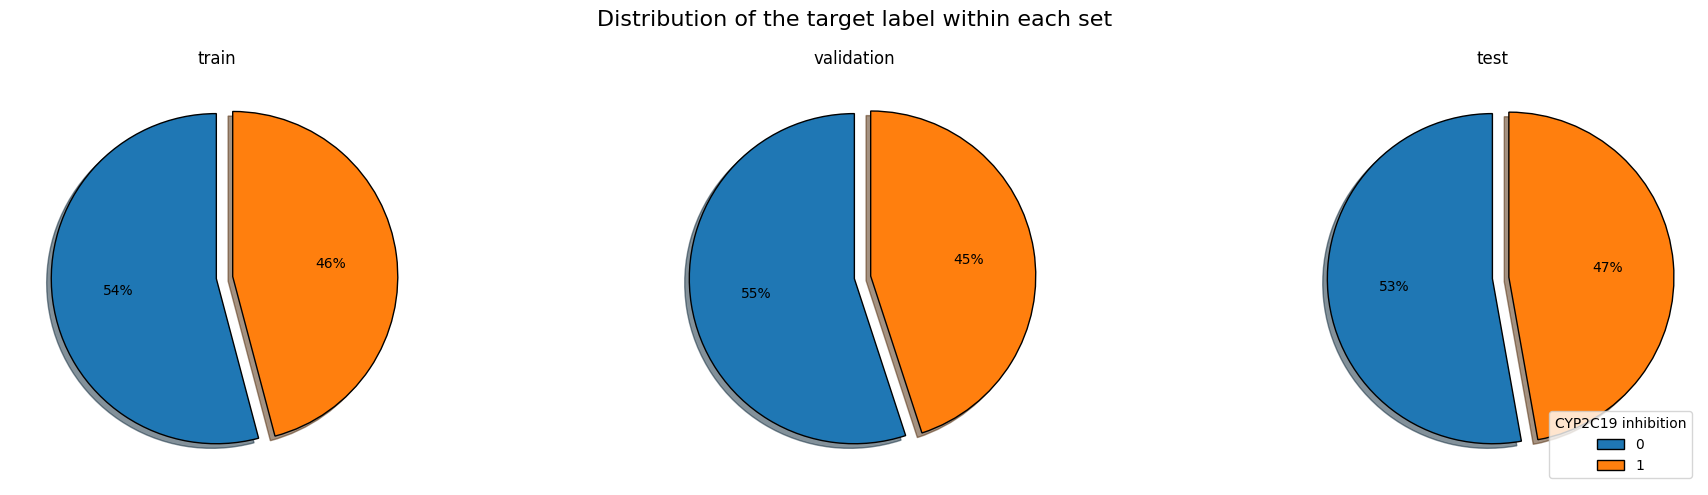

In [9]:
plot_counts(
    [datasets["train"]["Y"], datasets["val"]["Y"], datasets["test"]["Y"]],
    suptitle="Distribution of the target label within each set",
    titles=["train", "validation", "test"],
    legend_title="CYP2C19 inhibition",
    kind="pie",
)

The descriptors include discrete and continuous data, distinguished by their dtype. 

In [10]:
unique_dtypes = set(datasets["train"].dtypes)
print(f"Datatypes: {unique_dtypes}")

continuous_data_train = datasets["train"].select_dtypes(include='float64').join(datasets["train"]["Y"])
discrete_data_train = datasets["train"].select_dtypes(include='int64')

Datatypes: {dtype('float64'), dtype('int64'), dtype('O')}


### Continuous Data

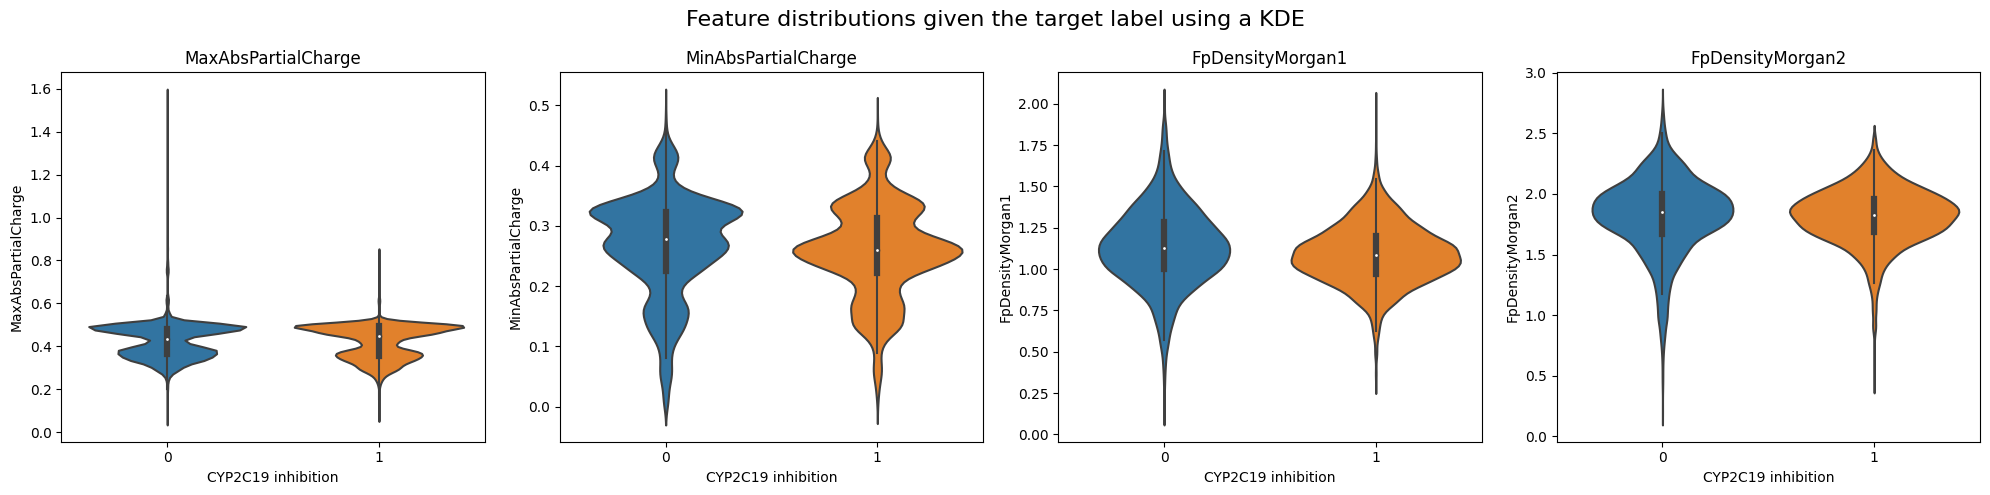

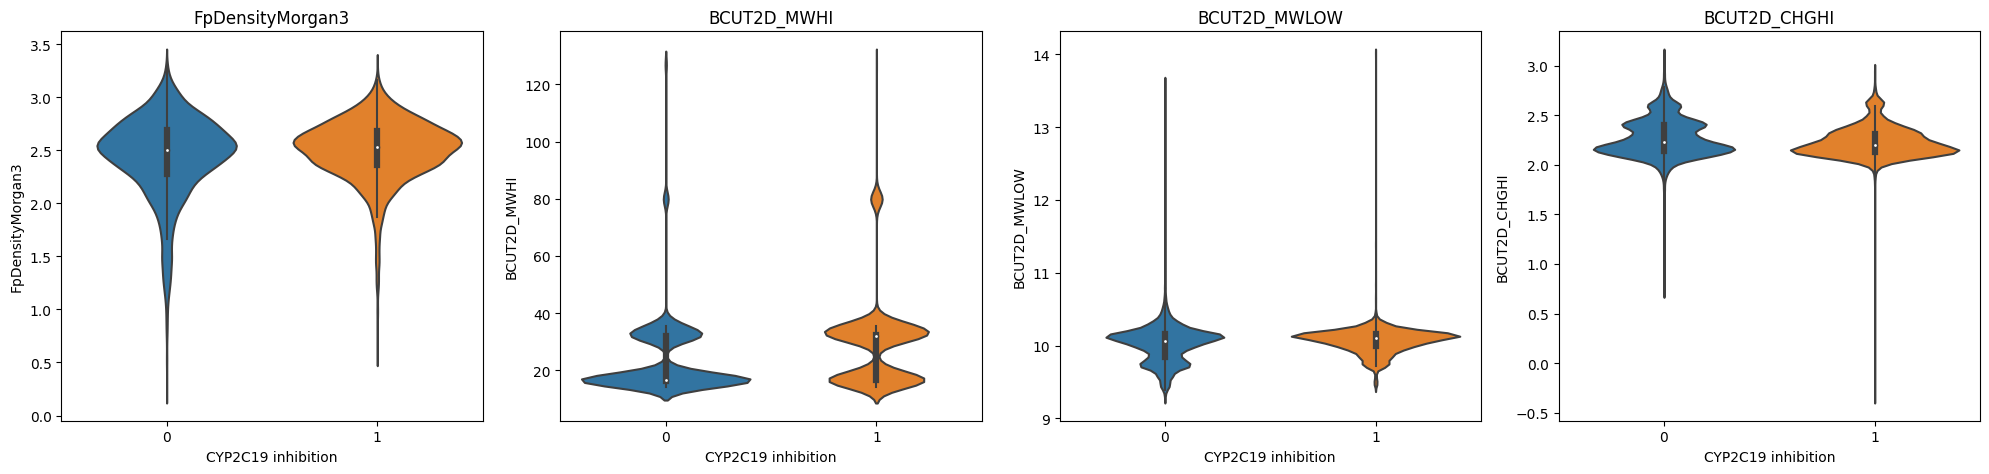

In [11]:
feature_distributions(
    data = continuous_data_train,
    features = continuous_data_train.columns[10:18],
    suptitle="Feature distributions given the target label using a KDE",
    x_label=f"{task} inhibition"
)

In [13]:
# Correlation matrix of descriptors
cor_matrix =  continuous_data_train.corr()
top_cor_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
fig = px.imshow(top_cor_matrix, color_continuous_scale='RdBu_r', title=f"{task} inhibition\nDescriptor correlation")

fig.write_html(f"data/{task.lower()}/descriptor_correlation.html")

### Discrete Data

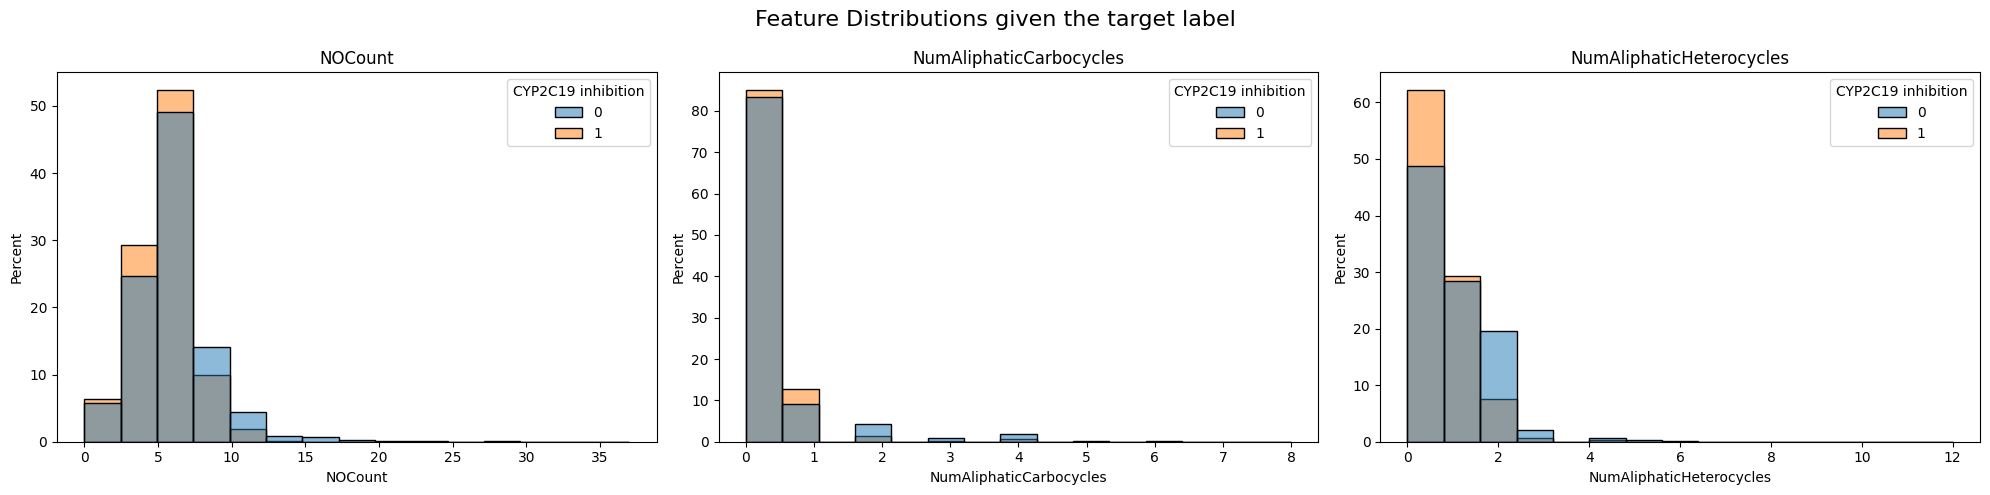

In [20]:
feature_distributions(
    data = discrete_data_train, 
    features = discrete_data_train.columns[5:8],
    kind = "hist",
    suptitle="Feature Distributions given the target label",
    legend_title="CYP2C19 inhibition",
)

## Building the Dataset

In [14]:
x_train = datasets["train"].drop(["Y"], axis=1)
y_train = datasets["train"]["Y"]

x_val = datasets["val"].drop(["Y"], axis=1)
y_val = datasets["val"]["Y"]

# TODO x_test, y_test, ...

## Feature Selection

There are in total 208 different descriptors. Relevant descriptors for the task of predicting CYP inhibition need to be selected to reduce the number of input variables to the clasical machine learning algorithm. Feature selection can either be performed unsupervised (without knowledge of the target label) or supervised.

**Note:** Some machine learning models have some form of feature selection inbuild, e.g. tree-based models. In those case we don't perform feature selection upfront.

Having a look at for example the number of radical electrons (NumRadicalElectrons) (<span style="color:cyan">TODO</span> Add description of NUmRadicalElectrons). We can see that all datapoints in the dataset have a value of 0 (min=max=0.0). 

In [15]:
print(summarize_descriptors(["NumRadicalElectrons"]))
datasets["train"].describe()["NumRadicalElectrons"]

{'NumRadicalElectrons': 'The number of radical electrons the molecule has (says nothing about spin state)'}


count    8841.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: NumRadicalElectrons, dtype: float64

In the area of feature selection there is a method called **variance threshold**: Given a threshold all features with a variance below this threshold will be removed. (<span style="color:cyan">TODO</span> Add better source; https://medium.com/nerd-for-tech/removing-constant-variables-feature-selection-463e2d6a30d9#:~:text=Variance%20Threshold%20is%20a%20feature,be%20used%20for%20unsupervised%20learning.)

The default value is usually 0 (removing constant features as they obviously bring no additional information to our model). If the variance threshold is greater than zero but still small we are removing quasi-constant features. The arguments against using a variance greater than 0 say that you may be moving variables that, although they have low variance, might actually be extremely powerful in explaining your target (dependent) variable.

For now, we are exploring which features are constant in our dataset.

In [16]:
print("Features with 0 variance:\n")
for index, n_unique in zip(datasets["train"].nunique(axis=0).index, datasets["train"].nunique(axis=0)):
    if n_unique == 1:
        print(index)

Features with 0 variance:

NumRadicalElectrons
SMR_VSA8
SlogP_VSA9
fr_isocyan
fr_prisulfonamd


In [17]:
# can take a Dataframe as input
pipe = Pipeline(steps=[
    ("remove_zero_var", VarianceThreshold(threshold=0.0))])
# pipe.fit(datasets["train"].drop(["Drug", "Drug_ID"], axis=1))

As shown in the correlation matrix there are some feature groups in our dataset with high correlation. In order to escape the curse of dimensionality we want to remove features with a high correlation to other features - out of two features with high correlation only one remains. When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. First, we plot a heatmap of the correlated features: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

The y-axis of the following dendrogram is a measure of closeness of either individual data points or clusters

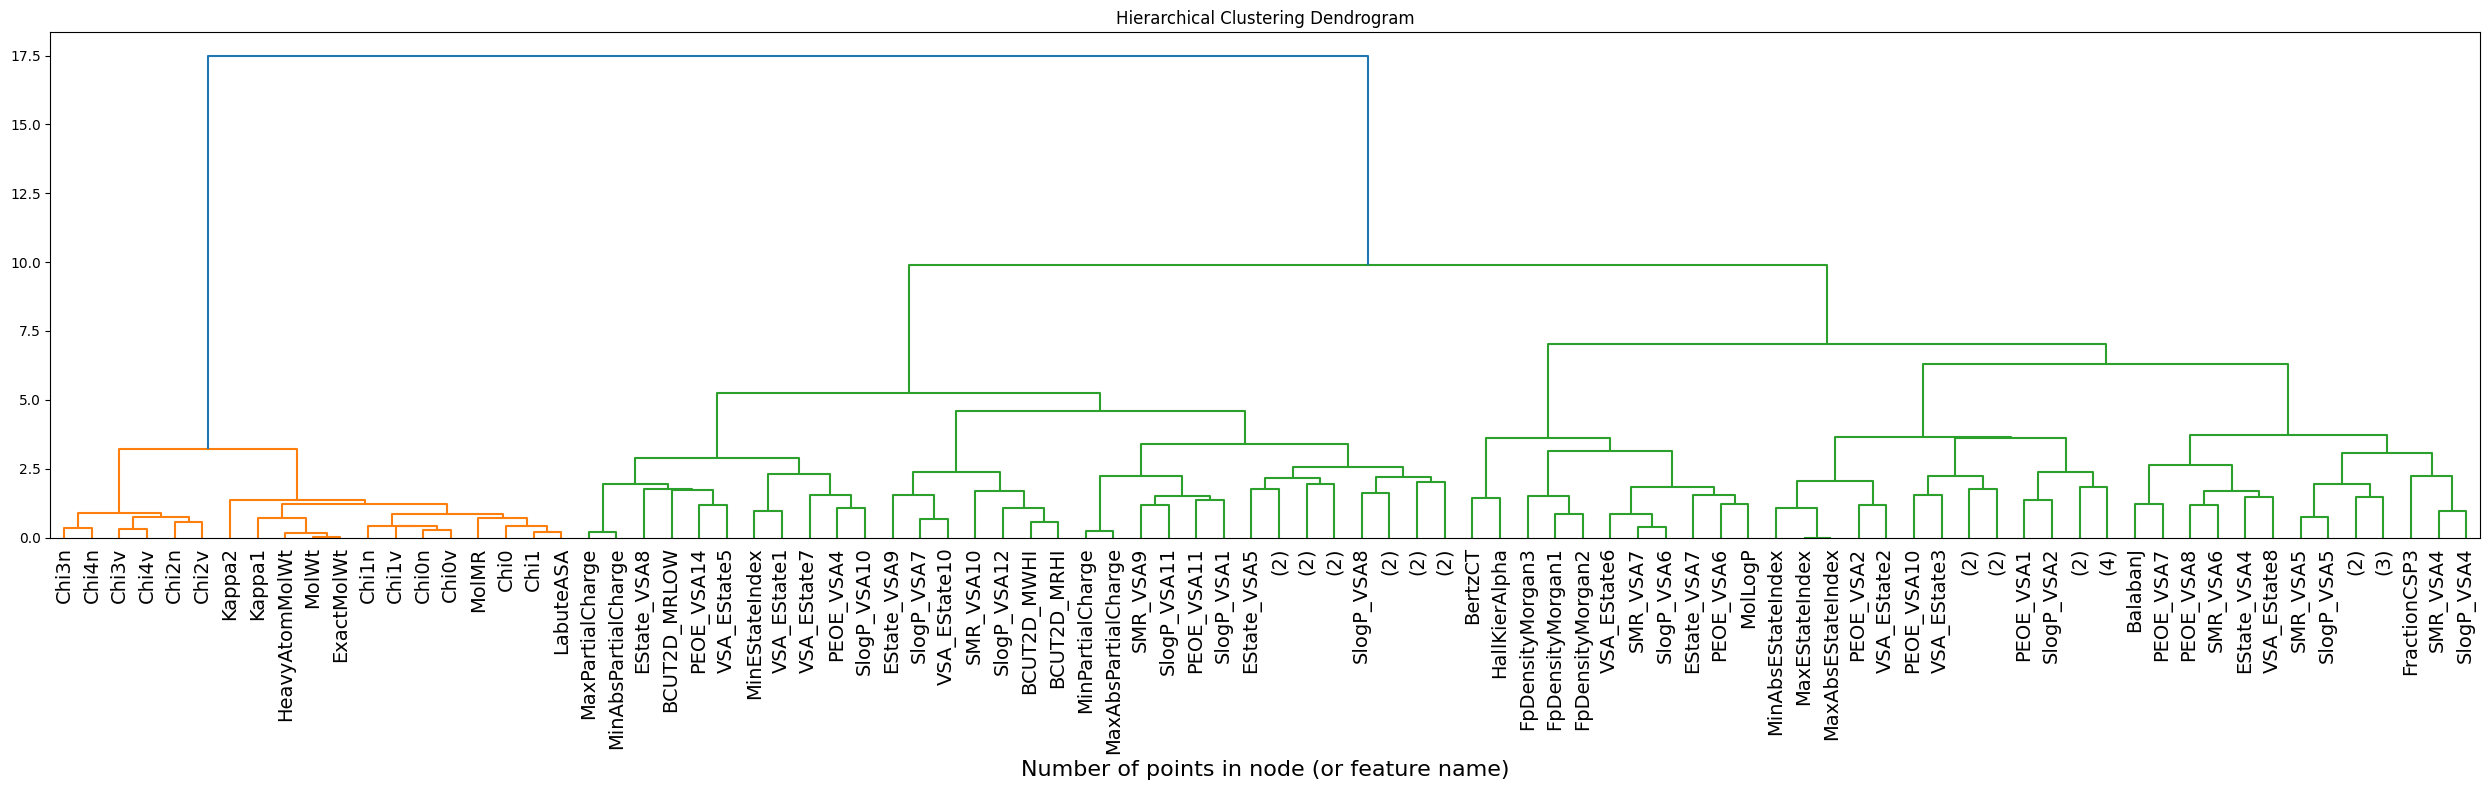

In [18]:
plot_dendrogram(cor_matrix, level=7)

In [19]:
features_high_correlation = [column for column in top_cor_matrix.columns if any(cor_matrix.abs()[column] > 0.97)]
features_high_correlation

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VS

# Next Steps

- Use Dendrogram [only continuous data] for feature selection (Jonna)
- Feature selection method for discrete data (James)
- Baseline
  - DummyClassifier
- Classical models
  - Random Forest (little feature selection) (Jonna)
  - KNN (James)
  - XGBoost (James)
  - SVM (Jonna)
  - Linear Models (Jonna)
  - Naive Bayes (James)
  - [later] simple NN
- Try giving weights to classes (will solve unbalanced data sets) (James)